# Neural Machine Translation with a transformer model

In this tutorial you'll learn how to create and train a transformer model to translate from deutsch to english using the Multi30k dataset.

Details:
* Framework: PyTorch
* Model: Transformer
* Task: Language Translation (de->en) 
* Packages: Torchtext, SpaCy
* Dataset: Multi30k

Installs: to run this tutorial, first install TorchText and SpaCy typing the following commands in your environment:

```
#Upgrade pip
pip install --upgrade pip

#Install torchtext
pip install torchtext

#Install spacy
conda install spacy # or pip install spacy

#Download English and German tokenizers
python -m spacy download en
python -m spacy download de
```

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, Iterator

import numpy as np
import matplotlib.pyplot as plt

import math
import time

print(f'Torch version: {torch.__version__}')

Torch version: 1.4.0


# Model

In [3]:
class TransformerModel(nn.Module):
    def __init__(self,
                 src_vocab_size: int,
                 trg_vocab_size: int,
                 d_model: int,
                 num_heads: int,
                 num_enc_layers: int,
                 num_dec_layers: int,
                 ffn_size: int,
                 dropout: float,
                 activation: str):
        
        super().__init__()
        
        self.d_model = d_model

        #Embeddings
        self.enc_embedding = nn.Embedding(num_embeddings = src_vocab_size, 
                                          embedding_dim = d_model)
        self.dec_embedding = nn.Embedding(num_embeddings = trg_vocab_size,
                                          embedding_dim = d_model)

        
        #Positional encoder
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        #Custom encoder
        #encoder_layer = TransformerEncoderLayer(d_model, num_heads, ffn_size, dropout, activation)
        #encoder_norm = nn.LayerNorm(d_model)
        #self.encoder = TransformerEncoder(encoder_layer, num_enc_layers, encoder_norm)
        
        #Custom decoder
        #decoder_layer = TransformerDecoderLayer(d_model, num_heads, ffn_size, dropout, activation)
        #decoder_norm = nn.LayerNorm(d_model)
        #self.decoder = TransformerDecoder(decoder_layer, num_dec_layers, decoder_norm)
        
        #Transformer
        self.transformer = nn.Transformer(d_model = d_model, 
                                          nhead = num_heads,
                                          num_encoder_layers = num_enc_layers,
                                          num_decoder_layers = num_dec_layers,
                                          dim_feedforward = ffn_size,
                                          dropout = dropout,
                                          activation = activation,
                                          custom_encoder = None, #self.encoder,
                                          custom_decoder = None) #self.decoder)
        
        #Linear layer
        self.fc = nn.Linear(d_model, trg_vocab_size)
        
        #Initialize weights
        self.init_weights()
    

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=1.0)
        
        nn.init.normal_(self.enc_embedding.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.dec_embedding.weight, mean=0.0, std=1.0)

        
    def forward(self, src: torch.tensor, trg: torch.tensor):
        trg_mask = self.generate_square_subsequent_mask(len(trg)).to(device)

        src = self.enc_embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        trg = self.dec_embedding(trg) * math.sqrt(self.d_model)
        trg = self.pos_encoder(trg)

        output = self.transformer(src, trg, tgt_mask = trg_mask)
        #>>output: [trg_len, batch_size, d_model]
        output = self.fc(output)
        #>>output: [trg_len, batch_size, trg_vocab_size]

        return output

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Train, evaluate and inference functions

In [5]:
def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip_value: float):
    
    model.train()

    loss_sum = 0

    for i, batch in enumerate(iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        #>>src: [src_len, batch_size]
        #>>trg: [trg_len, batch_size]

        output = model(src = src, trg = trg[:-1,:])
        #>>output: [trg_len-1, batch_size, trg_vocab_size]
        
        loss =  criterion(output.view(-1, output.shape[2]), trg[1:,:].view(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        
        loss_sum += loss.item()

    epoch_loss = loss_sum / len(iterator)
    return epoch_loss

In [6]:
def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):
    
    model.eval()
    
    loss_sum = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src.to(device)
            trg = batch.trg.to(device)
            #>>src: [src_len, batch_size]
            #>>trg: [trg_len, batch_size]

            src = src.to(device)
            trg = trg.to(device)

            output = model(src = src, trg = trg[:-1,:])
            #>>output: [trg_len-1, batch_size, trg_vocab_size]

            loss =  criterion(output.view(-1, output.shape[2]), trg[1:,:].view(-1))

            loss_sum += loss.item()

        epoch_loss = loss_sum / len(iterator)
    return epoch_loss

In [7]:
def inference(src: torch.tensor,
              model: nn.Module,
              max_len: int):
    """
    """
    
    model.eval()
    with torch.no_grad():
        #>>src: [src_len, batch_size]
        src = src.to(device)
        src = model.enc_embedding(src) * math.sqrt(model.d_model)
        #>>src: [src_len-1, batch_size]
        src = model.pos_encoder(src)
        memory = model.transformer.encoder(src)
        #>>memory: [src_len-1, batch_size, d_model]

        preds = torch.LongTensor([TRG.vocab.stoi['<sos>']]*src.shape[1]).reshape(1,src.shape[1]).to(device)
        #>>preds: [preds_len = 1, batch_size]
        for i in range(1, max_len):
            trg = preds
            trg_mask = model.generate_square_subsequent_mask(len(trg)).to(device)
            output = model.dec_embedding(trg) * math.sqrt(model.d_model)
            output = model.pos_encoder(output)
            output = model.transformer.decoder(output, memory, tgt_mask = trg_mask)
            #>>output: [trg_len = i, batch_size, d_model]
            output = model.fc(output)
            #>>output: [trg_len = i, batch_size, trg_vocab_size]
            pred = torch.argmax(output[-1,:,:], dim = -1).unsqueeze(0)
            #>>preds: [trg_len = 1, batch_size]
            preds = torch.cat((preds, pred), 0)
            #>>preds: [preds_len = i+1, batch_size]
        #>>preds: [preds_len = max_len, batch_size]
    return preds

In [8]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def epoch_time(start_time: int, end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Run the experiment

In [10]:
# Hyperparameters
tutorial_name = 'nmt_transformer_multik30'

BATCH_SIZE = 32
NUM_EPOCHS = 30

LR = 0.001
CLIP_VALUE = 1

D_MODEL = 128       #in the original paper 512
NUM_HEADS = 2       #in the original paper 8
NUM_ENC_LAYERS = 2  #in the original paper 6 
NUM_DEC_LAYERS = 2  #in the original paper 6
FFN_SIZE = 1024     #in the original paper 2048
DROPOUT_PROB = 0.2  #in the original paper 0.1

In [11]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [12]:
# Fields
SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            sequential = True,
            use_vocab = True,
            init_token = None, 
            eos_token = '<eos>',
            fix_length = None,
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False,
            pad_token = "<pad>",
            unk_token = "<unk>")

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            sequential = True,
            use_vocab = True,
            init_token = '<sos>', 
            eos_token = '<eos>',
            fix_length = None,
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False,
            pad_token = "<pad>",
            unk_token = "<unk>")

fields = [('src', SRC), ('trg', TRG)]

In [13]:
# Load dataset
train_data, dev_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                  fields = fields)

print(f'train_data size: {len(train_data)}')
print(f'dev_data size: {len(dev_data)}')
print(f'test_data size: {len(test_data)}')

train_data size: 29000
dev_data size: 1014
test_data size: 1000


In [14]:
# Vocabulary
SRC.build_vocab(train_data,
                max_size = None,
                min_freq = 2,
                vectors = None)

TRG.build_vocab(train_data,
                max_size = None,
                min_freq = 2,
                vectors = None)

print(f'src_vocab_size: {len(SRC.vocab)}')
print(f'trg_vocab_size: {len(TRG.vocab)}')

src_vocab_size: 7854
trg_vocab_size: 5893


In [15]:
# Iterators
iterators = BucketIterator.splits((train_data, dev_data, test_data),
                                    batch_size = BATCH_SIZE,
                                    sort_key = lambda x: len(x.src),
                                    device = None,
                                    shuffle = True)
train_iterator, dev_iterator, test_iterator = iterators

In [16]:
# Initialize the model
model = TransformerModel(src_vocab_size = len(SRC.vocab),
                         trg_vocab_size = len(TRG.vocab),
                         d_model = D_MODEL,
                         num_heads = NUM_HEADS,
                         num_enc_layers = NUM_ENC_LAYERS,
                         num_dec_layers = NUM_DEC_LAYERS,
                         ffn_size = FFN_SIZE,
                         dropout = DROPOUT_PROB,
                         activation = 'relu')

model = model.to(device)
print(model)

TransformerModel(
  (enc_embedding): Embedding(7854, 128)
  (dec_embedding): Embedding(5893, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
           

In [17]:
#Parameters
num_parameters = count_parameters(model)
print(f'\nnum_parameters: {num_parameters}')


num_parameters: 3972357


In [18]:
#Loss: CrossEntropyLoss calculates both nn.LogSoftmax() and nn.NLLLoss()
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [19]:
#Optimizer
optimizer = optim.Adam(params = model.parameters(), lr = LR)

In [20]:
# Training loop
print('\nTraining:')

history = {"train": {"loss": [], "acc": []}, "dev": {"loss": [], "acc": []}}
best_dev_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model = model,
                       iterator = train_iterator,
                       optimizer = optimizer,
                       criterion =  criterion,
                       clip_value = CLIP_VALUE)
  
    dev_loss = evaluate(model = model,
                        iterator = dev_iterator,
                        criterion =  criterion)
    
    history["train"]["loss"].append(train_loss)
    history["dev"]["loss"].append(dev_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), '../saved_models/'+tutorial_name+'.pt')
    
    #if epoch+1 == 1 or (epoch+1) % 10 == 0:
    print('-' * 80)
    print(f'Epoch: {epoch+1:03} | Time: {epoch_mins}m {epoch_secs}s | Train loss: {train_loss:.4f} | Dev loss: {dev_loss:.4f}')


Training:
--------------------------------------------------------------------------------
Epoch: 001 | Time: 0m 29s | Train loss: 4.1326 | Dev loss: 3.4552
--------------------------------------------------------------------------------
Epoch: 002 | Time: 0m 31s | Train loss: 3.4236 | Dev loss: 3.1261
--------------------------------------------------------------------------------
Epoch: 003 | Time: 0m 31s | Train loss: 3.0916 | Dev loss: 2.7982
--------------------------------------------------------------------------------
Epoch: 004 | Time: 0m 31s | Train loss: 2.8564 | Dev loss: 2.6452
--------------------------------------------------------------------------------
Epoch: 005 | Time: 0m 32s | Train loss: 2.6786 | Dev loss: 2.4854
--------------------------------------------------------------------------------
Epoch: 006 | Time: 0m 32s | Train loss: 2.5443 | Dev loss: 2.4213
--------------------------------------------------------------------------------
Epoch: 007 | Time: 0m 31s 

# Learning curves

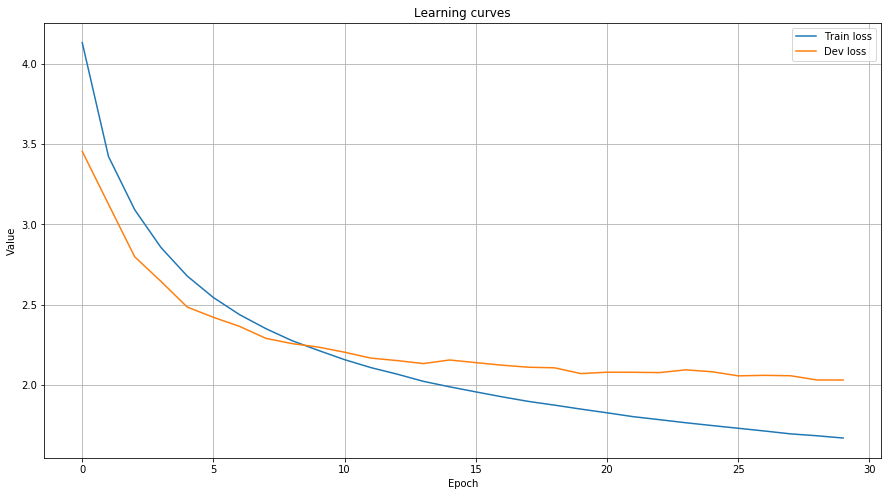

In [21]:
plt.figure(figsize=(15,8))
plt.plot(history["train"]["loss"], label='Train loss')
plt.plot(history["dev"]["loss"], label='Dev loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.title('Learning curves')
plt.grid(b=True)
plt.legend()
plt.show()

In [22]:
# Best dev loss
min_dev_loss = min(history["dev"]["loss"])
epoch = np.argmin(history["dev"]["loss"])+1
print(f'min_dev_loss: {min_dev_loss} , epoch: {epoch}')

min_dev_loss: 2.0306903459131718 , epoch: 30


# Evaluation

Evaluate on the test set

In [23]:
model.load_state_dict(torch.load('../saved_models/'+tutorial_name+'.pt'))
model = model.to(device)

test_loss = evaluate(model = model,
                     iterator = test_iterator,
                     criterion =  criterion)
    
print(f'Test loss: {test_loss:.4f}')

Test loss: 2.0493


# Inference

Take some test examples and check the trained model's predictions

In [24]:
# Load the best model
model.load_state_dict(torch.load('../saved_models/'+tutorial_name+'.pt'))
model = model.to(device)
#print(model)

In [25]:
#Take examples from the test data
infer_test_iterator = Iterator(test_data,
                                 batch_size = 10,
                                 sort_key = lambda x: len(x.src),
                                 device = device,
                                 shuffle = True,
                                 sort = False)

In [26]:
batch = next(iter(infer_test_iterator))
src = batch.src
trg = batch.trg
#>>src: [src_len, batch_size]
#>>trg: [trg_len, batch_size]

In [27]:
MAX_LEN = 25
preds = inference(src, model, MAX_LEN)
#>>preds: [preds_len = max_len, batch_size]

In [28]:
for i in range(src.shape[1]):
    print(f"\nDeutsch (src): {' '.join([SRC.vocab.itos[token] for token in src.permute(1,0)[i]])}")
    print(f"English (trg): {' '.join([TRG.vocab.itos[token] for token in trg.permute(1,0)[i]])}")
    print(f"English (pre): {' '.join([TRG.vocab.itos[token] for token in preds.permute(1,0)[i]])}")


Deutsch (src): ein kind sieht sich <unk> in einem geschäft an . <eos> <pad> <pad> <pad> <pad> <pad> <pad>
English (trg): <sos> a kid is looking at coffee machines inside a store . <eos> <pad> <pad> <pad> <pad> <pad> <pad>
English (pre): <sos> a child looking at a store . <eos> store . <eos> store . <eos> store . <eos> store . <eos> . <eos> . <eos>

Deutsch (src): ein hund trinkt draußen wasser auf dem gras . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
English (trg): <sos> a dog drinks water outside on the grass . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
English (pre): <sos> a dog is drinking water outside on the grass . <eos> drinking . <eos> . <eos> . <eos> . <eos> . <eos> . <eos>

Deutsch (src): ein mann auf einem motorrad zeigt einen trick auf einer rennstrecke . <eos> <pad> <pad> <pad> <pad>
English (trg): <sos> a man riding a motorcycle is performing a trick at a track . <eos> <pad> <pad> <pad> <pad>
English (pre): <sos> a man is demonstrating a motorcycle on a r

# That's it!